# Analyze the results of the 10-fold test!

## Performance by algorithm

## Warning!!! Delete all temp_*.txt csv files before rerunning test_kfold.sh

In [70]:
# Read the temp.csv file, which is generated automatically after each 10-fold test run with test_kfold.sh
# WARNING: Please delete the current temp.csv file each time before running a new 10-fold test
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv("../temp.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../temp.csv'

Performance by algorithm:


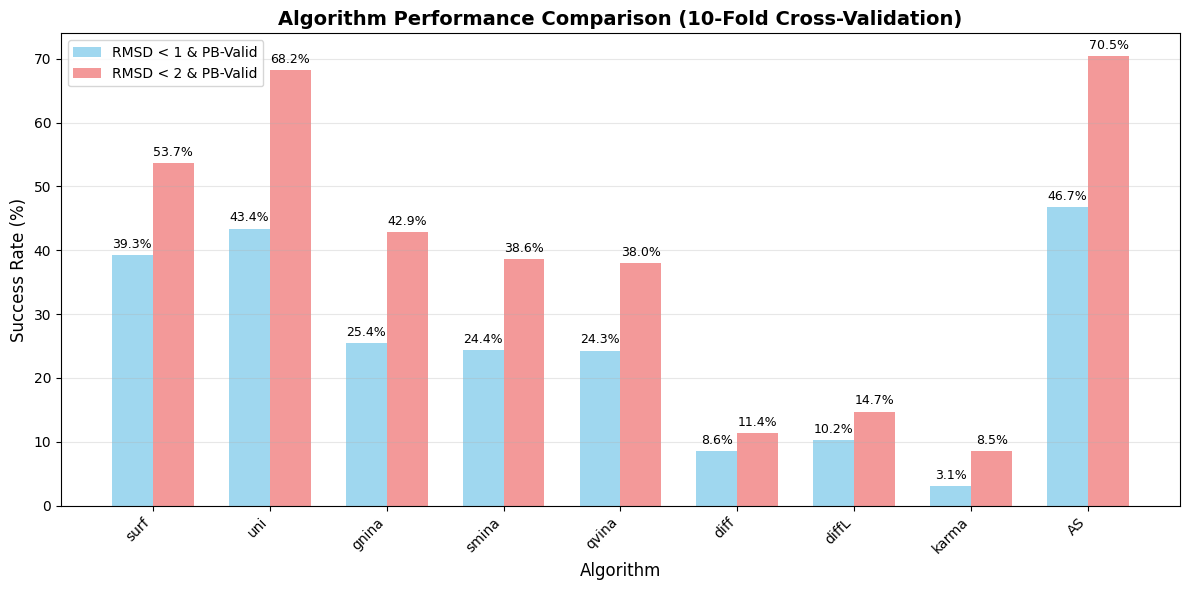


Statistical Summary:
Best performing algorithm (RMSD < 1): AS (46.74%)
Best performing algorithm (RMSD < 2): AS (70.46%)


In [ ]:
# Performance by algorithm
columns = ['surf', 'uni', 'gnina', 'smina', 'qvina', 'diff', 'diffL', 'karma']
perf_by_algo = dict()

print("Performance by algorithm:")

# Extract and store data
for algo in columns:
    if f'{algo}_rmsd_lt_1_valid' in data.columns and f'{algo}_rmsd_lt_2_valid' in data.columns:
        algo_percent_rmsd_lt_1_valid = data[f'{algo}_rmsd_lt_1_valid'].values
        algo_percent_rmsd_lt_2_valid = data[f'{algo}_rmsd_lt_2_valid'].values
        perf_by_algo[algo] = {
            "RMSD < 1 & PB-Valid": algo_percent_rmsd_lt_1_valid,
            "RMSD < 2 & PB-Valid": algo_percent_rmsd_lt_2_valid
        }

perf_by_algo["AS"] = {
    "RMSD < 1 & PB-Valid": data["AS_rmsd_lt_1_valid"].values,
    "RMSD < 2 & PB-Valid": data["AS_rmsd_lt_2_valid"].values
}

# Results graph
# Prepare data for plotting
algorithms = list(perf_by_algo.keys())
rmsd_lt_1_means = [perf_by_algo[algo]["RMSD < 1 & PB-Valid"].mean()*100 for algo in algorithms]
rmsd_lt_2_means = [perf_by_algo[algo]["RMSD < 2 & PB-Valid"].mean()*100 for algo in algorithms]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(algorithms))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, rmsd_lt_1_means, width, label='RMSD < 1 & PB-Valid', 
               capsize=5, alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, rmsd_lt_2_means, width, label='RMSD < 2 & PB-Valid',
               capsize=5, alpha=0.8, color='lightcoral')

# Customize the plot
ax.set_xlabel('Algorithm', fontsize=12)
ax.set_ylabel('Success Rate (%)', fontsize=12)
ax.set_title('Algorithm Performance Comparison (10-Fold Cross-Validation)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(algorithms, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nStatistical Summary:")
print(f"Best performing algorithm (RMSD < 1): {algorithms[np.argmax(rmsd_lt_1_means)]} ({max(rmsd_lt_1_means):.2f}%)")
print(f"Best performing algorithm (RMSD < 2): {algorithms[np.argmax(rmsd_lt_2_means)]} ({max(rmsd_lt_2_means):.2f}%)")

## Statistical Tests

In [ ]:
import scipy.stats as stats

# Wilcoxon p-test for results
# Is the performance gain with AS significant?
# Define algorithms and metrics
algorithms = ['surf', 'uni', 'gnina', 'smina', 'qvina', 'diff', 'diffL', 'karma']
metrics = ['rmsd_lt_1_valid', 'rmsd_lt_2_valid']
    
print("\n" + "="*80)
print("WILCOXON SIGNED-RANK TEST RESULTS")
print("="*80)
    
for algo in algorithms:
    print(f"\n--- {algo.upper()} ---")
        
    for metric in metrics:
        col_name = f"gain_from_{algo}_{metric}"
        print(col_name)

        if col_name in data.columns:
            gain_values = data[col_name].values
                
            # Remove NaN values if any
            gain_values = gain_values[~np.isnan(gain_values)]
                
            if len(gain_values) > 0:
                # Perform Wilcoxon signed-rank test
                try:
                    w_stat, w_p = stats.wilcoxon(gain_values, alternative='greater')
                        
                    # Calculate summary statistics
                    mean_gain = np.mean(gain_values)
                    median_gain = np.median(gain_values)
                    positive_gains = np.sum(gain_values > 0)
                    negative_gains = np.sum(gain_values < 0)
                    zero_gains = np.sum(gain_values == 0)
                    total_cases = len(gain_values)
                        
                    print(f"  {metric.replace('_', ' ').title()}:")
                    print(f"    Mean gain: {mean_gain:.3f}")
                    print(f"    Median gain: {median_gain:.3f}")
                    print(f"    Positive gains: {positive_gains}/{total_cases} ({100*positive_gains/total_cases:.1f}%)")
                    print(f"    Negative gains: {negative_gains}/{total_cases} ({100*negative_gains/total_cases:.1f}%)")
                    print(f"    Zero gains: {zero_gains}/{total_cases} ({100*zero_gains/total_cases:.1f}%)")
                    print(f"    Wilcoxon statistic: {w_stat:.4f}")
                    print(f"    P-value: {w_p:.6f}")
                        
                    # Significance indicator
                    if w_p < 0.001:
                        sig_level = "***"
                    elif w_p < 0.01:
                        sig_level = "**"
                    elif w_p < 0.05:
                        sig_level = "*"
                    else:
                        sig_level = ""
                        
                    print(f"    Significance: {sig_level}")
                        
                except ValueError as e:
                    print(f"  {metric.replace('_', ' ').title()}: Cannot perform test - {str(e)}")
            else:
                print(f"  {metric.replace('_', ' ').title()}: No valid data points")
        else:
            print(f"  {metric.replace('_', ' ').title()}: Column not found")
    
print("\n" + "="*80)
print("LEGEND: *** p<0.001, ** p<0.01, * p<0.05")
print("="*80)


WILCOXON SIGNED-RANK TEST RESULTS

--- SURF ---
gain_from_surf_rmsd_lt_1_valid
  Rmsd Lt 1 Valid:
    Mean gain: 0.075
    Median gain: 0.000
    Positive gains: 677/3179 (21.3%)
    Negative gains: 440/3179 (13.8%)
    Zero gains: 2062/3179 (64.9%)
    Wilcoxon statistic: 378443.0000
    P-value: 0.000000
    Significance: ***
gain_from_surf_rmsd_lt_2_valid
  Rmsd Lt 2 Valid:
    Mean gain: 0.168
    Median gain: 0.000
    Positive gains: 831/3179 (26.1%)
    Negative gains: 297/3179 (9.3%)
    Zero gains: 2051/3179 (64.5%)
    Wilcoxon statistic: 469099.5000
    P-value: 0.000000
    Significance: ***

--- UNI ---
gain_from_uni_rmsd_lt_1_valid
  Rmsd Lt 1 Valid:
    Mean gain: 0.033
    Median gain: 0.000
    Positive gains: 284/3179 (8.9%)
    Negative gains: 178/3179 (5.6%)
    Zero gains: 2717/3179 (85.5%)
    Wilcoxon statistic: 65746.0000
    P-value: 0.000000
    Significance: ***
gain_from_uni_rmsd_lt_2_valid
  Rmsd Lt 2 Valid:
    Mean gain: 0.023
    Median gain: 0.000
    

## Algorithm selection portfolio

In [ ]:
# Read the temp_portfolio.csv file, which is generated automatically after each 10-fold test run with test_kfold.sh
# WARNING: Please delete the current temp_portfolio.csv file each time before running a new 10-fold test
data_portfolio = pd.read_csv("../temp_portfolio.csv")
algorithm_counts = data_portfolio['selected_algorithm'].value_counts()
print(algorithm_counts)

selected_algorithm
uni      2007
smina     492
surf      484
gnina     105
qvina      65
diffL      26
Name: count, dtype: int64
